(sec_msprime_demography)=

# Demography

**Georgia Tsambos**

By default, {func}`msprime.sim_ancestry` simulates samples from a single population of a constant size,
which isn't particularly exciting!
One of the strengths of msprime is that it can be used to specify quite complicated
models of demography and population history with a simple Python API.

In [1]:
import msprime
import numpy as np

## Population structure

``msprime`` supports simulation from multiple discrete populations,
each of which is initialized in {class}`msprime.Demography` via the {meth}`msprime.Demography.add_population` method.
For each population, you can specify a sample size, an effective population size
at time = 0, an exponential growth rate and a name.

Suppose we wanted to simulate three sequences each from two populations
with a constant effective population size of 500.

In [2]:
dem = msprime.Demography()
dem.add_population(name="A", description="Plotted in red.", initial_size=500)
dem.add_population(name="B", description="Plotted in blue.",initial_size=500)
dem  

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,A,Plotted in red.,500.0,0,0,{}
1,B,Plotted in blue.,500.0,0,0,{}


The {class}`msprime.Demography` object that we've just created can be passed to {func}`msprime.sim_ancestry` via the ``demography`` argument.
We'll also use the ``samples`` argument to specify how many sample inividuals we wish to draw from each of these populations.
In this case, we'll simulate three from each.
Also, note that we no longer need to specify ``population_size`` in {func}`msprime.sim_ancestry` as we have provided a separate size for each population.

In [3]:
# ts = msprime.sim_ancestry(
#   samples={"A" : 3, "B" : 3}, 
#   demography=dem,
#   random_seed=12,
#   sequence_length=1000, 
#   recombination_rate=1e-4
#   )

However, **this simulation will run forever** unless we also
specify some migration between the groups!
To understand why, recall that ``msprime`` is a `coalescent`-based simulator.
The simulation will run backwards-in-time, simulating until `all` samples have
coalesced to a single common ancestor at each genomic location.
However, with no migration between our two populations, samples in one
population will never coalesce with samples in another population.
To fix this, let's add some migration events to the specific demographic history.

```{note}
In this default setup, the samples will be drawn from time = 0, but see [here](https://tskit.dev/msprime/docs/latest/ancestry.html#sampling-time) if you wish to change this.
```

```{note}
Population structure in ``msprime`` closely follows the model used in the
``ms`` simulator.
Unlike ``ms`` however, all times and rates are specified
in generations and all population sizes are absolute (that is, not
multiples of ``population_size``).
```

## Migrations

With msprime, you can specify continual rates of migrations between
populations, as well as admixture events, divergences and one-off mass migrations.

### Constant migration

![constant-migration-diagram](_static/tute-population-structure-1.png)

Migration rates between the populations can be thought as the elements of an
*N* by *N* numpy array, and are passed to our {class}`msprime.Demography` object individually via the {meth}`msprime.Demography.set_migration_rate`
method.
This allows us to specify the expected number of migrants moving
from population `dest` to population `source` per generation, divided by the size of
population `source`.  When this rate is small (close to 0), it is approximately
equal to the fraction of population `source` that consists of new migrants from
population `dest` in each generation.
And if both of your populations are exchanging migrants at the same rate, you can save yourself some typing by specifying them with a single {meth}`msprime.Demography.set_symmetric_migration_rate` call.

```{note}
The reason for this (perhaps) counter-intuitive specification of `source` and `dest` is that ``msprime`` simulates backwards-in-time. See [this](https://tskit.dev/msprime/docs/latest/demography.html#direction-of-time) for further explanation.
```

For instance, the following migration matrix specifies that in each generation,
approximately 5% of population 0 consists of migrants from population 1, and
approximately 2% of population 1 consists of migrants from population 0.

In [4]:
dem = msprime.Demography()
dem.add_population(name="A", description="Plotted in red.", initial_size=500)
dem.add_population(name="B", description="Plotted in blue.",initial_size=500)

# Set migration rates.
dem.set_migration_rate(source=0, dest=1, rate=0.05)
dem.set_migration_rate(source=1, dest=0, rate=0.02)

# Simulate.
ts = msprime.sim_ancestry(
  samples={"A" : 1, "B" : 1},
  demography=dem,
  sequence_length=1000,
  random_seed=141,
  recombination_rate=1e-7)
ts

One consequence of specifying {class}`msprime.Population` objects
is that each of the simulated nodes will now belong to one of our specified
populations:

In [5]:
ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,
1,1,0,0,0.00000000,
2,1,1,1,0.00000000,
3,1,1,1,0.00000000,
4,0,0,-1,161.20712736,
5,0,1,-1,336.10713452,
6,0,1,-1,590.71203375,


Notice that the ``population`` column of the node table now contains values of 0 and 1.
If you are working in a Jupyter notebook, you can draw the tree sequence
with nodes coloured by population label using SVG:

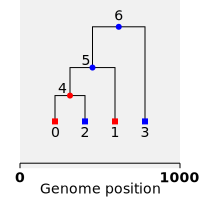

In [6]:
colour_map = {0:"red", 1:"blue"}
styles = [f".node.p{p} > .sym {{fill: {col} }}" for p, col in colour_map.items()]
# The code below will only work in a Jupyter notebook with SVG output enabled.
ts.draw_svg(style="".join(styles))

More coalescences are happening in population 1 than population 0.
This makes sense given that population 1 is specifying more migrants to
population 0 than vice versa.

### Changing migration rates

We can change any of the migration rates at any time in the simulation.
To do this, we just need to use the {meth}`msprime.Demography.add_migration_rate_change` method on our {class}`msprime.Demography` object,
specifying the populations whose migration rates are to be changed,
the time of the change and the new migration rate.

For instance, say we wanted to specify that in each generation prior to
time = 100, 1% of population 0 consisted of migrants from population 1.

In [7]:
dem.add_migration_rate_change(time=100, rate=0.01, source=0, dest=1)
dem

Demography(populations=[Population(initial_size=500, growth_rate=0, name='A', description='Plotted in red.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=500, growth_rate=0, name='B', description='Plotted in blue.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1)], events=[MigrationRateChange(time=100, rate=0.01, source=0, dest=1)], migration_matrix=array([[0.  , 0.05],
       [0.02, 0.  ]]))

The output above shows that we have successfully added our first demographic event to our {class}`msprime.Demography` object, a migration rate change.
We are now ready to simulate:

In [8]:
ts = msprime.sim_ancestry(
  samples={"A" : 1, "B" : 1},
  demography=dem,
  sequence_length=1000,
  random_seed=63461,
  recombination_rate=1e-7)
ts

### Admixture and population splits

#### Admixture

It is also easy to specify admixture and divergence events with msprime.
Suppose we wanted to specify our demography so that 50 generations ago,
30% of population 0 was a migrant from population 1:

```{todo}
make a diagram showing this
```

We can do this by using the {meth}`msprime.Demography.add_admixture` method on our demography object.
We must supply a list of ancestral populations participating in the admixture, and a list of the same size specifying the proportions of migrants from each of these populations.

In [9]:
dem = msprime.Demography()
dem.add_population(name="AncestralPop0", description="Plotted in red.", initial_size=500, growth_rate=0)
dem.add_population(name="AncestralPop1", description="Plotted in blue.", initial_size=500, growth_rate=0)
dem.add_population(name="AdmixedPop", description="Plotted in green.", initial_size=500)
dem.set_migration_rate(source=0, dest=1, rate=0.05)
dem.set_migration_rate(source=1, dest=0, rate=0.02)

# Specify admixture event.
dem.add_admixture(time=50, derived="AdmixedPop", ancestral=["AncestralPop0", "AncestralPop1"], proportions=[0.3, 0.7]);

This simulates a sample where all nodes (ancestral haplotypes) are from the admixed population up until the time of the admixture event, and before this, all nodes are from one of the ancestral populations.

In [10]:
ts = msprime.sim_ancestry(
  samples={"AncestralPop0" : 0, "AncestralPop1" : 0, "AdmixedPop" : 6},
  demography=dem,
  sequence_length=1000,
  random_seed=63,
  recombination_rate=1e-7)

print("Populations of nodes from time < 50:")
print([u.population for u in ts.nodes() if u.time < 50])
print("Populations of nodes from time >= 50:")
print([u.population for u in ts.nodes() if u.time >= 50])

Populations of nodes from time < 50:
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Populations of nodes from time >= 50:
[1, 1, 1, 1, 0, 1, 1, 1, 0, 1]


Admixtures and population splits are special types of demographic events that affect the *state* of some of the defined populations, in addition to moving lineages between populations.
The output below shows that by adding the admixture event, we are triggering a change in the state of ``AdmixedPop`` at time = 50;
the population is active at the start of the simulation, but becomes inactive for all steps of the simulation beyond time 50.

In [11]:
dem

Demography(populations=[Population(initial_size=500, growth_rate=0, name='AncestralPop0', description='Plotted in red.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=500, growth_rate=0, name='AncestralPop1', description='Plotted in blue.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=500, growth_rate=0, name='AdmixedPop', description='Plotted in green.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2)], events=[Admixture(time=50, derived='AdmixedPop', ancestral=['AncestralPop0', 'AncestralPop1'], proportions=[0.3, 0.7])], migration_matrix=array([[0.  , 0.05, 0.  ],
       [0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.  ]]))

This means that, for example, adding any demographic events that affect ``AdmixedPop`` beyond this time will produce an error:

In [12]:
dem.add_migration_rate_change(time=80, rate=0.01, source="AncestralPop0", dest="AdmixedPop");
# ts = msprime.sim_ancestry(
#   samples={"AncestralPop0" : 0, "AncestralPop1" : 0, "AdmixedPop" : 6},
#   demography=dem,
#   sequence_length=1000,
#   random_seed=63,
#   recombination_rate=1e-7)

To read more about the way that msprime treats the life cycle of populations, see [here](https://tskit.dev/msprime/docs/latest/demography.html#sec-demography-populations-life-cycle).

#### Population splits

We can also simulate population divergences with msprime.
Suppose we want to model a situation where all lineages from multiple populations are migrants from a single ancestral population at a single point in time.

```{todo}
make a diagram showing this
```

We'll specify this with the {meth}`msprime.Demography.add_population_split` method.
We need to know the time of the event, and the IDs or labels of the derived and ancestral populations participating in the divergence event.
Notice that in this case, we do not need to provide proportions as we did in the case of admixture.
This makes sense when you think about the fact that msprime simulates backwards-in-time: all lineages in all of the derived populations originate from the ancestral population in a split event.
Any differences in 'quantities' of migrants must be modelled by sizes of the derived populations at the time of the split.

In [13]:
dem = msprime.Demography()
dem.add_population(name="A", description="Plotted in red.", initial_size=500)
dem.add_population(name="B", description="Plotted in blue.",initial_size=500)
dem.add_population(name="AncestralPopulation", description="Plotted in green.", initial_size=500)

# Add the population split.
dem.add_population_split(time=100, derived=["A","B"], ancestral="AncestralPopulation")
dem

Demography(populations=[Population(initial_size=500, growth_rate=0, name='A', description='Plotted in red.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=500, growth_rate=0, name='B', description='Plotted in blue.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=500, growth_rate=0, name='AncestralPopulation', description='Plotted in green.', extra_metadata={}, default_sampling_time=100, initially_active=False, id=2)], events=[PopulationSplit(time=100, derived=['A', 'B'], ancestral='AncestralPopulation')], migration_matrix=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]))

Population splits will also modify the state of each of the derived populations,
changing them from active to inactive at the time of the split.

In [14]:
ts = msprime.sim_ancestry(
  samples={"A" : 3, "B" : 3, "AncestralPopulation" : 0},
  demography=dem,
  sequence_length=1000,
  random_seed=63,
  recombination_rate=1e-7)

print("Populations of nodes from time < 100:")
print([u.population for u in ts.nodes() if u.time < 100])
print("Populations of nodes from time >= 100:")
print([u.population for u in ts.nodes() if u.time >= 100])

Populations of nodes from time < 100:
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Populations of nodes from time >= 100:
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


### Mass migrations

If you used any of versions of msprime prior to 1.0,
you may be familiar with mass migration events.
These are used to specify one-off events in which some fraction of a population moves into another population, and can be supplied to a {class}`msprime.Demography` object using the {meth}`msprime.Demography.add_mass_migration` method.

```{warning}
Unlike {meth}`msprime.Demography.add_admixture` and {meth}`msprime.Demography.add_population_split` mentioned above, {meth}`msprime.Demography.add_mass_migration` **does not** change any population states or migration rates. We **strongly recommend** that you use the more specialised methods to model admixture and divergence events -- it is both simpler and safer!
```
You'll need to provide the time of the mass migration in generations,
the ID of the source and destination populations,
and a migration proportion.

![](_static/tute-mass-migration.png)

For example, the following specifies that 50 generations ago,
30% of population 0 was a migrant from population 1.

In [15]:
dem = msprime.Demography()
dem.add_population(name="A", description="Plotted in red.", initial_size=500)
dem.add_population(name="B", description="Plotted in blue.",initial_size=500)
dem.set_migration_rate(source=0, dest=1, rate=0.05)
dem.set_migration_rate(source=1, dest=0, rate=0.02)

# Add the mass migration.
dem.add_mass_migration(time=50, source=0, dest=1, proportion=0.3)
dem

Demography(populations=[Population(initial_size=500, growth_rate=0, name='A', description='Plotted in red.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=500, growth_rate=0, name='B', description='Plotted in blue.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1)], events=[MassMigration(time=50, source=0, dest=1, proportion=0.3)], migration_matrix=array([[0.  , 0.05],
       [0.02, 0.  ]]))

Note that these are viewed as backwards-in-time events,
so ``source`` is the population that receives migrants from ``dest``.

In [16]:
ts = msprime.sim_ancestry(
  samples={"A" : 3, "B" : 3},
  demography=dem,
  sequence_length=1000,
  random_seed=63461,
  recombination_rate=1e-7)

## Changing population sizes or growth rates

![](_static/tute-parameter-changes.png)

We may wish to specify changes to rates of population growth,
or sudden changes in population size at a particular time.
Both of these can be specified by applying the {meth}`msprime.Demography.add_population_parameters_change`
method to our {class}`msprime.Demography` object.

In [17]:
dem = msprime.Demography()
dem.add_population(name="A", description="Plotted in red.", initial_size=500)
dem.add_population(name="B", description="Plotted in blue.",initial_size=500)
dem.set_migration_rate(source=0, dest=1, rate=0.05)
dem.set_migration_rate(source=1, dest=0, rate=0.02)

# Bottleneck in Population 0 between 50 - 150 generations ago.
dem.add_population_parameters_change(time=50, initial_size=250, population=0)
dem.add_population_parameters_change(time=150, initial_size=500, population=0)

# Exponential growth in Population 1 starting 50 generations ago.
dem.add_population_parameters_change(time=100, growth_rate=0.01, population=1)

# Sort events, since we've added some out of time order.
dem.sort_events()

# Simulate.
ts = msprime.sim_ancestry(samples={"A" : 3, "B" : 3}, demography=dem, sequence_length=1000, random_seed=63461, recombination_rate=1e-7)

Note that because ``msprime`` simulates backwards-in-time, parameter changes must be
interpreted backwards-in-time as well.
For instance, the ``pop1_growth`` event in the example above
specifies continual growth in the early history of population 1 up until 100
generations in the past.

## Census events

There may be situations where you are particularly interested in the chromosomes that are ancestral to your simulated sample at a particular time.
For instance, you might want to know how many different lineages are ancestral to your sample at some past time.
Perhaps you are interested to know which populations these ancestors belonged to (ie. *local ancestry*).
In both cases, msprime can help you by allowing you to add a *census* to your simulation at a particular time.
This is done with the {meth}`msprime.Demography.add_census`
 method:

In [18]:
dem = msprime.Demography()
dem.add_population(name="A", initial_size=500)

# Add a census at time 350.
dem.add_census(time=350)

# Simulate.
ts = msprime.sim_ancestry(
  samples={"A" : 2},
  demography=dem,
  sequence_length=1000,
  random_seed=112,
  recombination_rate=1e-7)

The effect of the census is to add nodes onto each branch of the tree sequence at the census time.

IDs of census nodes:
[5, 6, 7]


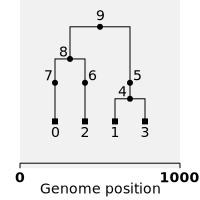

In [19]:
print("IDs of census nodes:")
print([u.id for u in ts.nodes() if u.flags==msprime.NODE_IS_CEN_EVENT])
ts.draw_svg()

By extracting these node IDs, you can perform further analyses using the ancestral haplotypes.
See [here](https://tskit.dev/msprime/docs/latest/ancestry.html#census-events) for a slightly more involved example of this.

## Debugging demography

As we've seen, it's pretty easy to make mistakes when specifying demography!

To help you spot these, msprime provides a debugger that prints out your
population history in a more human-readable form.
It's good to get into the habit of running the {class}`msprime.DemographyDebugger`
before running your simulations.

In [20]:
my_history = msprime.DemographyDebugger(demography=dem)
my_history

,start,end,growth_rate
A,500.0,500.0,0
time,type,parameters,effect
350,Census,,Insert census nodes to record the location of all lineages
,start,end,growth_rate
A,500.0,500.0,0
